# Feature Engineering

### Setup

In [1]:
import os
import time
import json

import numpy as np
import pandas as pd

import urlextract
from datetime import datetime
from nltk.stem import WordNetLemmatizer

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-05


### Load Data

In [2]:
# load X, y train subsets
raw_path = os.path.join("..","data","1_raw")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# create arrays
X_array = np.array(X_train.iloc[:,0]).ravel()
y_array = np.array(y_train.iloc[:,0]).ravel()

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### New Features

In [3]:
%%capture output

# custom feature engineering module
import feature_engineering as Fe

try:
    clean_docs, X_transformed = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_array)
except Warning as e:
    pass

Fix empty values which generate NaN.

In [4]:
[(ix, val) for ix, val in enumerate(X_array[12:15])]

[(0, "K come to nordstrom when you're done"),
 (1, ':-) :-)'),
 (2, 'Okay... I booked all already... Including the one at bugis.')]

In [5]:
[(ix, val) for ix, val in enumerate(clean_docs[12:15])]

[(0, 'k come to nordstrom when you are done'),
 (1, ''),
 (2, 'okay i booked all already including the one at bugis')]

In the new feature space:

In [6]:
#dlen_raw  dlen_cln n_tokns tkn_maxL tkn_meanL tkn_stdL rsr_
print(X_transformed[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.         nan     nan  0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


#### Impute `NaNs` with $0$s.

In [7]:
X_transformed[np.isnan(X_transformed)] = 0
print(X_transformed[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.      0.      0.      0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('std_scaler', StandardScaler()), 
                 ('log_reg', LogisticRegression(solver="liblinear", random_state=42))])

Using the pipeline just to scale then perform cross validation with a model.

In [9]:
X_scaled = pipe['std_scaler'].fit_transform(X_transformed)

In [10]:
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)

score = cross_val_score(log_clf, X_scaled, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8785 (+/- 0.0093)


Using the full pipeline and predicting once.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_array, test_size=0.33, random_state=42)

pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_preds):0.4f}')

Accuracy: 0.8718


### Dotument-Term Matrix plus engineered features


In [12]:
import cleanup_module as Cmod
from sklearn.feature_extraction.text import TfidfTransformer

dtm_pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=2)),
                     ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=2000))
                    ])

In [13]:
X_transformed_dtm = dtm_pipe.fit_transform(X_array)

In [14]:
X_transformed_dtm

<3900x2001 sparse matrix of type '<class 'numpy.intc'>'
	with 57752 stored elements in Compressed Sparse Row format>

In [15]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)

score = cross_val_score(log_clf, X_transformed_dtm, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.9854 (+/- 0.0059)



- *What will combining them result in?*

#### Scaled vs Unscaled


In [16]:
import scipy.sparse as sp

X_stacked_scaled = sp.hstack((X_scaled, X_transformed_dtm))
X_stacked_unscaled = sp.hstack((X_transformed, X_transformed_dtm))
X_stacked_scaled, X_stacked_unscaled

(<3900x2008 sparse matrix of type '<class 'numpy.float64'>'
 	with 85052 stored elements in COOrdinate format>,
 <3900x2008 sparse matrix of type '<class 'numpy.float64'>'
 	with 85015 stored elements in COOrdinate format>)

In [17]:
# scaled
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_stacked_scaled, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.9854 (+/- 0.0065)


In [18]:
# unscaled
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_stacked_unscaled, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.9846 (+/- 0.0065)


- What about using SVD for dimentionality reduction and then stacking the new features?

### SVD plus New Features

In [19]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

U, Sigma, VT = svds(X_transformed_dtm.asfptype().T, # transposed to a term-document matrix
                    k=300) # k = number of components / "topics"
    
# reverse outputs
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

In [20]:
U.shape, Sigma.shape, VT.shape

((2001, 300), (300,), (300, 3900))

In [21]:
V = VT.T
V.shape, y_array.shape

((3900, 300), (3900,))

In [22]:
# convert to sparse matrix
V_sparse = sp.csr_matrix(V)
X_scaled_sparse = sp.csr_matrix(X_scaled)

# stack
V_stacked = sp.hstack((V_sparse, X_scaled_sparse))
V_stacked

<3900x307 sparse matrix of type '<class 'numpy.float64'>'
	with 1197000 stored elements in COOrdinate format>

**SVD alone**

In [23]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)

score = cross_val_score(log_clf, V_sparse, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8674 (+/- 0.0012)


**SVD plus new features**

In [24]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)

score = cross_val_score(log_clf, V_stacked, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8967 (+/- 0.0115)


Just raw document length?

In [25]:
V_stacked = sp.hstack((V_sparse, X_transformed[:,0:1]))
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V_stacked, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8513 (+/- 0.0084)


Just clean document length?

In [26]:
V_stacked = sp.hstack((V_sparse, X_transformed[:,1:2]))
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V_stacked, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8515 (+/- 0.0086)


Just number of tokens?

In [27]:
V_stacked = sp.hstack((V_sparse, X_transformed[:,2:3]))
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, V_stacked, y_array, cv=10, verbose=0, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

Accuracy: 0.8533 (+/- 0.0085)


- Adding the new features to SVD degrade its accuracy.
- It's possible that a more complex algorithm such as Random Forests might yield different results.

### Precision-Recall Curves

In [28]:
# transform y_array into int type
y_array[y_array=='ham'] = 0
y_array[y_array=='spam'] = 1
y_array=y_array.astype('int')

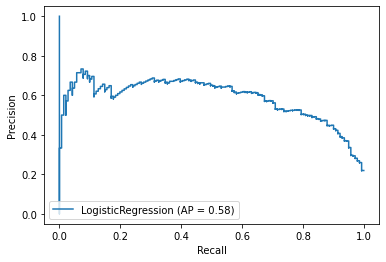

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_transformed, 
                                                    y_array, test_size=.25, random_state=42)
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)
d=plot_precision_recall_curve(log_clf, X_test, y_test)

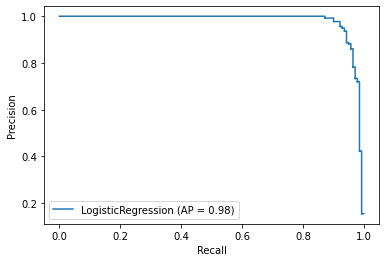

In [30]:
X_train, X_test, y_train, y_test = train_test_split(V_sparse, # SVD alone
                                                    y_array, test_size=.25, random_state=42)
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)
d=plot_precision_recall_curve(log_clf, X_test, y_test)

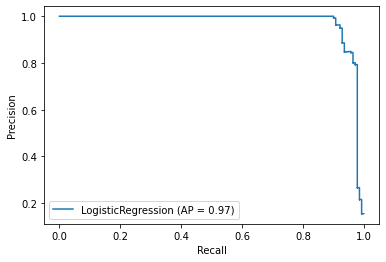

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed_dtm, # full 2000-term DTM
                                                    y_array, test_size=.25, random_state=42)
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)
d=plot_precision_recall_curve(log_clf, X_test, y_test)

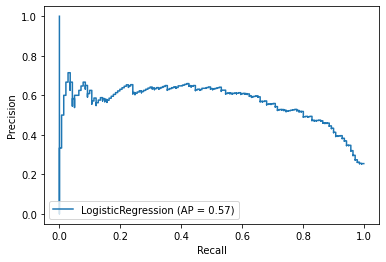

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_sparse,
                                                    y_array, test_size=.25, random_state=42)
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)
d=plot_precision_recall_curve(log_clf, X_test, y_test)

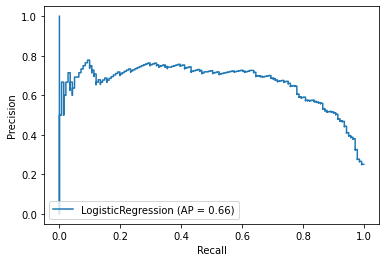

In [33]:
X_train, X_test, y_train, y_test = train_test_split(sp.hstack((V_sparse, X_scaled_sparse)),
                                                    y_array, test_size=.25, random_state=42)
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_train, y_train)
d=plot_precision_recall_curve(log_clf, X_test, y_test)

---

In [34]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 1 m 40 s
